In [1]:
import numpy as np
import matplotlib.pyplot as plt

from avapi.carla import CarlaScenesManager

data_root = "/data/shared/CARLA/multi-agent-intersection"
CSM = CarlaScenesManager(data_dir=data_root)
CDM = CSM.get_scene_dataset_by_index(0)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from fov.segmentation.preprocess import point_cloud_to_image, point_cloud_to_gt_seg


frames = CDM.frames
pc = CDM.get_lidar(frame=frames[0], sensor="lidar-0", agent=0)

img_in = point_cloud_to_image(pc, extent=[[-100, 100], [-100, 100]])
gt_seg, gt_img = point_cloud_to_gt_seg(pc, extent=[[-100, 100], [-100, 100]])

/home/spencer/.cache/pypoetry/virtualenvs/fov-security-pWvESQ_k-py3.10/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [40]:
import cv2

with open()
img_file = "/data/shared/fov/fov_bev_segmentation/img/train/00000001.png"
img_np = np.frombuffer(img_file)
# cv2.imdecode()

TypeError: a bytes-like object is required, not 'str'

In [39]:
from mmseg.apis import show_result_pyplot
from avstack.modules.perception.fov_estimator import MMSegBevFovSegmenter


model = MMSegBevFovSegmenter("unet", "carla", iteration=500)
result = model(img_in)
img_in_exp = np.repeat(img_in[:, :, None], 3, 2)
vis_image = show_result_pyplot(
    model.model, img_in_exp, result, draw_gt=False, show=False, out_file="img_out.png"
)

/home/spencer/Documents/Projects/Research/attack-perception/3-fov-security/submodules/lib-avstack-core/third_party/mmsegmentation/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/home/spencer/Documents/Projects/Research/attack-perception/3-fov-security/submodules/lib-avstack-core/third_party/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/spencer/Documents/Projects/Research/attack-perception/3-fov-security/submodules/lib-avstack-core/third_party/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you woul

Loads checkpoint by local backend from path: /home/spencer/Documents/Projects/Research/attack-perception/3-fov-security/submodules/lib-avstack-core/third_party/mmsegmentation/work_dirs/unet_fov/iter_500.pth


In [ ]:
plt.imshow(gt_img)
plt.show()

In [65]:
from avstack.modules.perception.fov_estimator import FastRayTraceBevLidarFovEstimator
from avstack.modules.perception.fov_estimator import SlowRayTraceBevLidarFovEstimator

# set up fov models
fov_estimator_fast = FastRayTraceBevLidarFovEstimator(z_min=-3.0, z_max=3.0)
fov_estimator_slow = SlowRayTraceBevLidarFovEstimator(z_min=-3.0, z_max=3.0)

# get some random lidar point clouds to analyze
seed = 10
rng = np.random.RandomState(seed=seed)
n_pcs = 1
pcs = []
frames = CDM.get_frames(sensor="lidar-0", agent=0)
random_agent_frames = list(
    zip(
        rng.randint(0, 4, size=n_pcs),
        rng.choice(list(range(200)), size=n_pcs, replace=False),
    )
)
pcs = [
    CDM.get_lidar(frame=frames[idx_frame], sensor="lidar-0", agent=agent)
    for agent, idx_frame in random_agent_frames
]

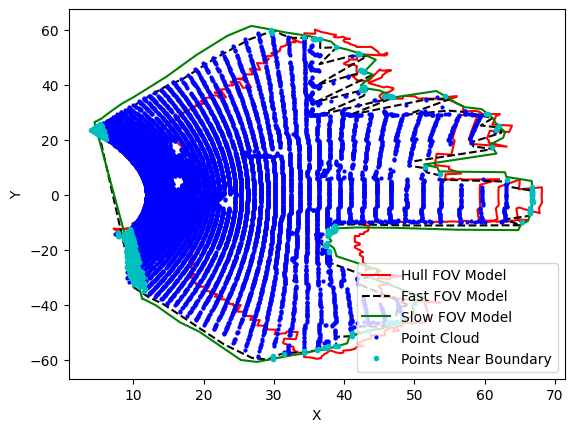

In [9]:
for pc in pcs:
    # run fov estimator on this frame
    fov_hull = pc.concave_hull_bev(concavity=1)
    fov_fast = fov_estimator_fast(pc)
    fov_slow = fov_estimator_slow(pc)

    # project lidar to bev for plotting
    pc_bev = pc.project_to_2d_bev()

    # get points close to boundary to highlight
    pts_close_to_fov = fov_slow.distance_points(pc_bev.data.x[:, :2]) < 1

    # make plot
    plt.plot(
        fov_hull.boundary[:, 0], fov_hull.boundary[:, 1], "r-", label="Hull FOV Model"
    )
    plt.plot(
        fov_fast.boundary[:, 0], fov_fast.boundary[:, 1], "k--", label="Fast FOV Model"
    )
    plt.plot(
        fov_slow.boundary[:, 0], fov_slow.boundary[:, 1], "g-", label="Slow FOV Model"
    )
    plt.plot(
        pc_bev.data.x[:, 0],
        pc_bev.data.x[:, 1],
        "bo",
        markersize=2,
        label="Point Cloud",
    )
    plt.plot(
        pc_bev.data.x[pts_close_to_fov, 0],
        pc_bev.data.x[pts_close_to_fov, 1],
        "co",
        markersize=3,
        label="Points Near Boundary",
    )
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.show()

In [ ]:
# run execution timing check
n_pcs_timing = 10
%timeit for pc in pcs[:n_pcs_timing]:fov_estimator_fast(pc)
%timeit for pc in pcs[:n_pcs_timing]:fov_estimator_slow(pc)

## Run a simple unit test

In [ ]:
from avstack.geometry import Position, ReferenceFrame, GlobalOrigin3D


def make_far_reference():
    return ReferenceFrame(
        x=np.array([100, 100, 0]), q=np.quaternion(1), reference=GlobalOrigin3D
    )


pc_local = CDM.get_lidar(frame=frames[0], sensor="lidar-0", agent=0)

# run fov estimator in a simple frame
fov_estimator = FastRayTraceBevLidarFovEstimator()
fov_local = fov_estimator(pc_local, in_global=False)
pt_local = Position(np.array([-20, 0, 0], dtype=float), reference=pc_local.reference)
assert fov_local.check_point(pt_local.x)

# convert the fov frame using change reference
pc_far = pc_local.change_calibration(make_far_reference(), inplace=False)
pt_far = pt_local.change_reference(pc_far.reference, inplace=False)
fov_local_as_far = fov_local.change_reference(pc_far.reference, inplace=False)
assert fov_local_as_far.check_point(pt_far.x)

# run fov estimator in a different frame
fov_far = fov_estimator(pc_far, in_global=False)
assert fov_far.check_point(pt_far.x)

In [ ]:
# show in a local frame
plt.plot(
    pc_local.data.x[:, 0],
    pc_local.data.x[:, 1],
    "bo",
    alpha=0.2,
    markersize=2,
    label="Point Cloud",
)
plt.plot(
    fov_local.boundary[:, 0], fov_local.boundary[:, 1], "k--", label="Fast FOV Model"
)
plt.plot(pt_local.x[0], pt_local.x[1], "gx", markersize=10, label="point")
plt.show()

# show in the transformed frame
plt.plot(
    pc_far.data.x[:, 0],
    pc_far.data.x[:, 1],
    "bo",
    alpha=0.2,
    markersize=2,
    label="Point Cloud",
)
plt.plot(
    fov_local_as_far.boundary[:, 0],
    fov_local_as_far.boundary[:, 1],
    "k--",
    label="Fast FOV Model",
)
plt.plot(pt_far.x[0], pt_far.x[1], "gx", markersize=10, label="point")
plt.show()

# show in the far frame
plt.plot(
    pc_far.data.x[:, 0],
    pc_far.data.x[:, 1],
    "bo",
    alpha=0.2,
    markersize=2,
    label="Point Cloud",
)
plt.plot(fov_far.boundary[:, 0], fov_far.boundary[:, 1], "k--", label="Fast FOV Model")
plt.plot(pt_far.x[0], pt_far.x[1], "gx", markersize=10, label="point")
plt.show()